# VASCA result analysis example TDS
Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder. The output of the pipline was stored in the folder vasca_pipeline. Enter the region to be analysed below (assumes to contain the field PS_ELAISN1_MOS15)

In [3]:
region_name = "TDS_ELAISN1" #

### Basic region information

In [4]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

#from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits


from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.utils import mag2flux

region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"

rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)
sel_srcs = rg.tt_sources["sel"]
display(rg.tt_sources[sel_srcs])
#rg.info() # Show available tables

field_id,field_name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes8,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6
GFU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,FUV,1.2,True,5,6920.1,54960.17787037037,56504.46356481482,7


fd_src_id,nr_det,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs
,,deg,deg,arcsec,,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int32,int32,int32
-1,30 .. 10,242.13060936798834,54.3523625457429,0.09614244,-2.8281225e-12,0.28089592,0.3171416,0.7565285,578,0.087940216,1 .. 2,True,16.78025 .. 8.580403,0.17863573 .. 0.32719588,0.017031763 .. 0.0049133627,5.7768245 .. 1.5590423,6.498947e-22 .. 0.23379327,5.867683 .. 1.2943969,0.9652967 .. 0.99654776,-2.6476834 .. -0.06395665,-1,138,4
-1,26 .. 8,242.0676640852736,55.059630217822864,0.10780618,-2.4219678e-12,0.5327372,0.00019151901,1.3054521,651,0.07680857,1 .. 2,True,18.707722 .. 8.331066,0.2144001 .. 0.37781793,0.03977333 .. 0.0057240454,15.173762 .. 1.6968313,0.0 .. 0.27151927,12.497078 .. 1.2492235,0.9642922 .. 0.9943161,-2.5763137 .. -0.09590326,-1,161,4
-1,14 .. 9,242.04054801564757,55.66992174404936,0.13234603,9.406493e-12,1.1145688,1.6698442e-09,2.644297,690,0.5029386,1 .. 2,True,31.807138 .. 29.84446,0.37305507 .. 0.59499085,0.1034116 .. 0.009600699,106.73671 .. 11.839424,0.0 .. 2.3062817e-05,52.978798 .. 4.4190345,1.0082431 .. 0.9838487,0.61446154 .. -0.6056687,-1,170,4
-1,25 .. 2,242.03953596190982,54.35869108386325,0.12266665,8.9789775e-13,1.0623472,9.341775e-05,1.5361999,692,0.20017214,1 .. 2,True,13.369682 .. 2.9400222,0.19070622 .. 0.39705026,3.6105638 .. 0.19186775,646.90314 .. 2.0226746,0.0 .. 0.018444598,403.81128 .. 5.5534215,0.7241175 .. 1.2836407,-20.402456 .. 1.3661038,-1,172,4
-1,12 .. 8,241.99259653903638,54.84628847667065,0.13996045,-1.568746e-12,0.5731474,0.0015521533,1.4292951,748,0.32351285,1 .. 2,True,45.62678 .. 16.359665,0.44421855 .. 0.48281956,0.028509662 .. 0.012937807,61.765736 .. 5.784729,0.0 .. 0.00044659153,25.948744 .. 3.7560031,1.060674 .. 0.90414053,5.3437395 .. -2.551196,-1,192,4
-1,44 .. 10,241.8941499453672,55.633550202239775,0.07642179,-1.9552426e-12,0.26415,0.32917094,0.8082673,851,0.10642356,1 .. 2,True,48.898117 .. 25.104078,0.22824778 .. 0.517051,0.016425302 .. 0.0022314459,41.692738 .. 4.1154766,0.0 .. 0.1373825,17.249659 .. 1.5108277,0.98487306 .. 0.9909624,-2.4748182 .. -0.32260674,-1,230,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,20 .. -1,240.97542502218974,55.18011377898948,0.14948756,-4.5346045e-12,0.17507675,0.94335324,0.38637567,110436,0.0488431,1 .. -1,True,7.8361626 .. -1.0,0.19068721 .. -1.0,0.0321073 .. -100.0,2.7241755 .. -1.0,4.1708165e-07 .. -1.0,3.4745295 .. -1.0,0.99253523 .. 1.0,-0.22571507 .. 0.0,-1,40231,1


### Basic info source TDE PS1-10jh

Found VASCA source is at distance: 0.0002980614819505658 deg


field_id,field_name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id,fd_src_id
,,deg,deg,,,deg,,,s,d,d,,
bytes22,bytes22,float64,float64,bytes22,bytes8,float32,bool,int32,float32,float64,float64,int32,int32[1]
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5,1679


fd_src_id,nr_det,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs
,,deg,deg,arcsec,,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int32,int32,int32
-1,9 .. -1,242.36799405563585,53.6734928074704,0.21433103,-3.5976873e-12,0.32065862,0.32529438,0.7639206,82424,0.17213278,1 .. -1,True,7.9562874 .. -1.0,0.26963854 .. -1.0,10.7397785 .. -100.0,680.8981 .. -1.0,0.0 .. -1.0,297.64703 .. -1.0,1.0412223 .. 1.0,0.98138565 .. 0.0,-1,29870,1


vis_id,fd_src_id,ra,dec,pos_err,flux,flux_err,s2n,obs_filter_id,sel,rg_fd_id,rg_src_id
,,deg,deg,arcsec,1e-06 Jy,1e-06 Jy,,,,,
int64,int32,float64,float64,float32,float32,float32,float32,int32,bool,int32,int32
2597664391344160768,1679,242.36820101585513,53.67362779732314,0.82956064,2.3334231,0.65552974,3.5595992,1,True,5,29870
2597664391109279744,1679,242.3676087982485,53.67350456522766,0.6748421,4.4393206,0.7365625,6.0270796,1,True,5,29870
2597664391176388608,1679,242.3678701766545,53.67354550274539,0.68921536,6.193512,0.7272987,8.515776,1,True,5,29870
2597664391209943040,1679,242.36794187408043,53.67332903707245,0.7006945,5.9253736,0.75601786,7.8376107,1,True,5,29870
2597664391142834176,1679,242.3678646423442,53.67336978366317,0.6912552,5.4714675,0.69646895,7.8560104,1,True,5,29870
2597664391277051904,1679,242.36793383819526,53.673376313246045,0.6901429,5.0972424,0.8218123,6.2024417,1,True,5,29870
2597664391243497472,1679,242.36809043633627,53.673386801808135,0.6797218,5.6501956,0.7712134,7.326371,1,True,5,29870
2597664390975062016,1679,242.36807120218452,53.67364529001413,0.5255185,54.91735,1.6375269,33.536762,1,True,5,29870


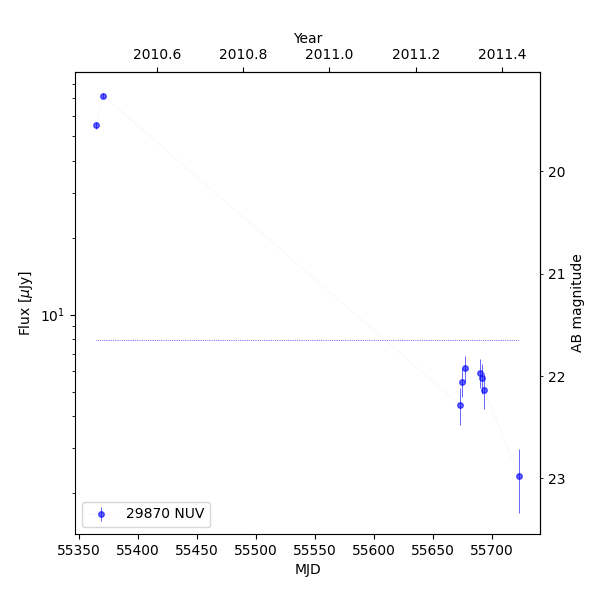

In [5]:
# αJ2000 = 16h09min28.296s, δJ2000 = +53 deg 40′ 23.52′′ from arXiv:1205.0252 in field "GNU2597664528044916736"
#logger.enable("vasca")

src_ps1tde, dist = rg.get_src_from_sky_pos('16h09m28.296s', '+53d40m23.52s')
print("Found VASCA source is at distance:",dist.degree,"deg")

fig_lc, ax_lc = vvis.plot_light_curve(src_ps1tde,rg_src_ids=src_ps1tde.tt_sources["rg_src_id"][0])
display(src_ps1tde.tt_fields)
display(src_ps1tde.tt_sources)
display(src_ps1tde.tt_detections)

### Display TDE PS1-10jh field in the sky

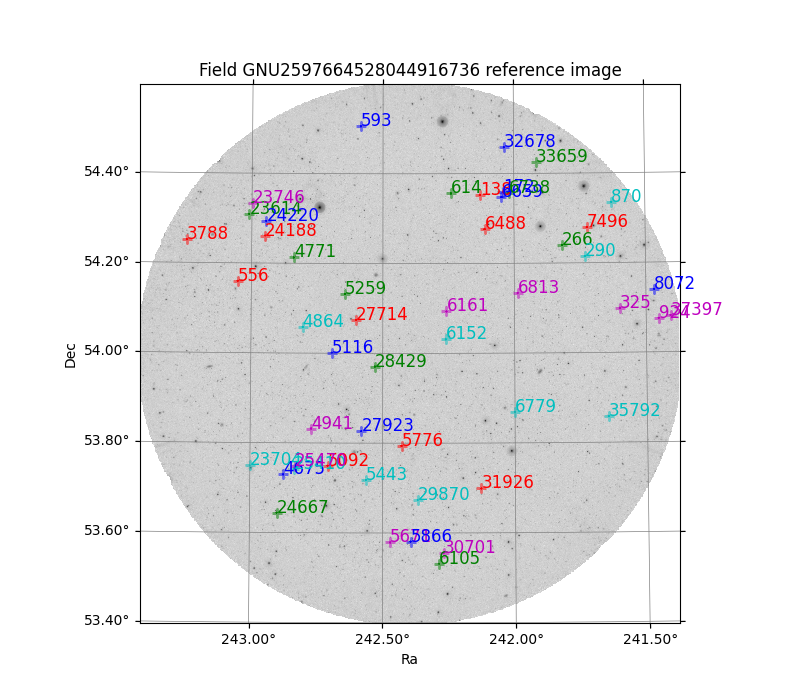

In [6]:
fd = rg.get_field(field_id=src_ps1tde.tt_fields[0]["field_id"], load_method="FITS", add_field=True)
fd_src_id = src_ps1tde.tt_fields["fd_src_id"][0]

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs)) # 
#display(Table(fd.tt_sources[src_idx]))

### Show TDS coverage maps

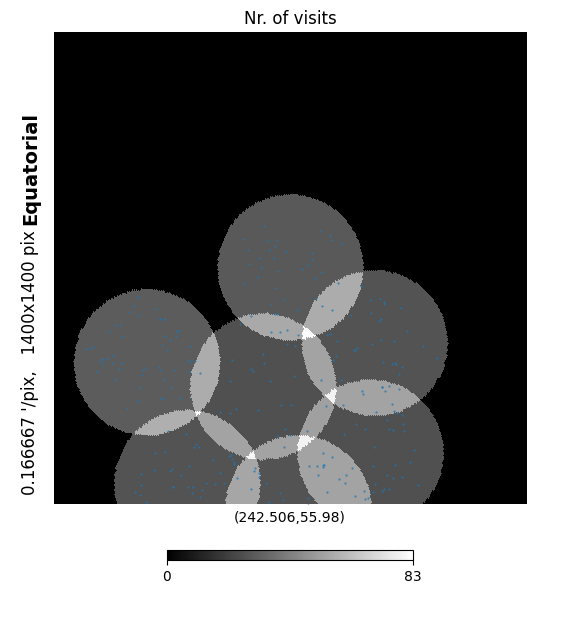

In [7]:
#logger.enable("vasca")
plot_coverage = True
if plot_coverage:
    rg.add_coverage_hp(nside=4096, coord_sys="icrs")
    #vvis.plot_region_sky_mollview(rg, var="nr_vis")
    #vvis.plot_region_sky_mollview(rg, var="nr_fds")
    #vvis.plot_region_sky_mollview(rg, var="exp")
    #rg.add_coverage_hp(nside=4096, )
    vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[0]["ra"],rg.tt_fields[0]["dec"])
    #vvis.plot_region_sky_mollview(rg)

### Sky image with Imviz, show source and detection markers on-top

In [8]:
show_imviz = False
if show_imviz:
    hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
    imviz = Imviz()
    viewer = imviz.default_viewer
    imviz.load_data(hdup, data_label=str(field_id))
    imviz.show(loc='sidecar')

    sel_det = fd.tt_detections["sel"]
    tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
    viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
    viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

    srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
    tt_srcs_sky = Table({'coord':srcs_sky })
    viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
    viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')